In [75]:
from __future__ import print_function, division

# Standard imports to work with datasets, plots, etc.
import pylab as pl
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import json
import requests
import urllib2
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.interpolate import *

#loading rcParams from JSON template (created from Federica's fbb_matplotlibrc.json)
url = 'https://s3.amazonaws.com/sb-public/sbg389_matplotlibrc.json'
resp = requests.get(url=url)
data = json.loads(resp.text)
# update the rcParams object
pl.rcParams.update(data)

# Will use Citibike Data for the graph
#imports downloader
from getCitiBikeCSV import getCitiBikeCSV

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['polyint', 'griddata', 'insert']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [43]:
datestring = '201501'
getCitiBikeCSV(datestring)

df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
df.head()

('Downloading', '201501')
file in place, you can continue


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1


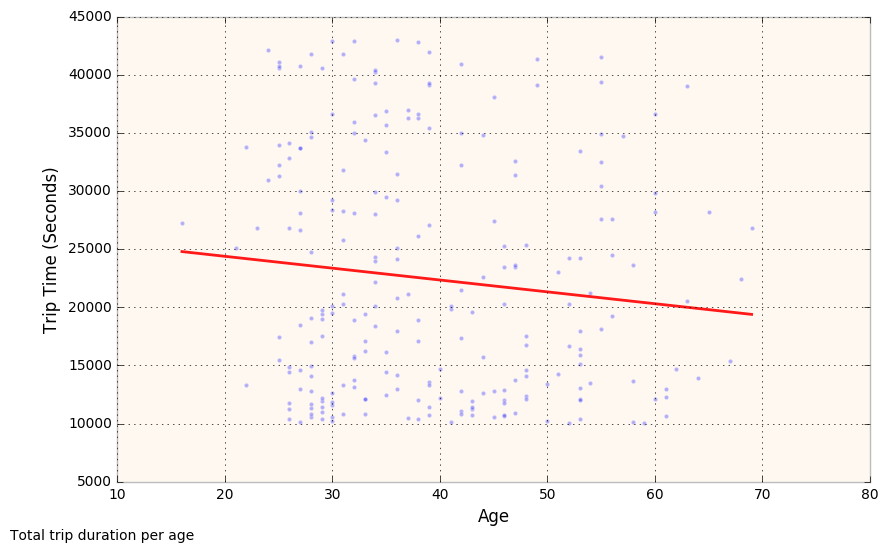

In [79]:
# Will graph the trip duration as a dependent variable from age to see if there is any relation
# Create age column
df['age'] = 2015 - df['birth year']

#clean columns
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['tripduration'] = pd.to_numeric(df['tripduration'], errors='coerce')
df.dropna(axis=0, inplace=True )

msk =  ((df.age > 0) & (df.tripduration > 0) & (df.age < 70) & (df.tripduration > 10000))
df = df[msk]

y = df.tripduration  # response
X = df.age  # predictor
X = sm.add_constant(X)  # Adds a constant term to the predictor
X.head()

# use the sm OLS method passing the y (existing data for what i want to predict) and the predictor X
est = (sm.OLS(y, X))

# run the fit method
est = est.fit()
est.summary()

# Pick 100 hundred points equally spaced from the min to the max
X_prime = np.linspace(X.age.min(), X.age.max(), 70)[:, np.newaxis]
X_prime = sm.add_constant(X_prime)  # add constant as we did before

# Now we calculate the predicted values
y_hat = est.predict(X_prime)

pl.figure(figsize=(6 * 1.618, 6))
pl.xlabel("Age")
pl.ylabel("Trip Time (Seconds)")
pl.text(0,-20,'Total trip duration per age')
pl.scatter(df.age, df.tripduration, s=10, alpha=0.3 )
pl.plot(X_prime[:, 1], y_hat, 'r', alpha=0.9)


In [87]:
dfGdp = pd.read_csv('https://github.com/datasets/gdp/raw/master/data/gdp.csv')
dfGdp = dfGdp[(dfGdp['Country Name'] == 'Uruguay')]
dfGdp.head()

# Lets predict

y = dfGdp.Value  # response
X = dfGdp.Year  # predictor
X = sm.add_constant(X)  # Adds a constant term to the predictor
X.head()

# use the sm OLS method passing the y (existing data for what i want to predict) and the predictor X
est = (sm.OLS(y, X))

# run the fit method
est = est.fit()
est.summary()

# Pick 100 hundred points equally spaced from the min to the max
X_prime = np.linspace(X.Year.min(), X.Year.max(), 40)[:, np.newaxis]
X_prime = sm.add_constant(X_prime)  # add constant as we did before

# Now we calculate the predicted values
y_hat = est.predict(X_prime)


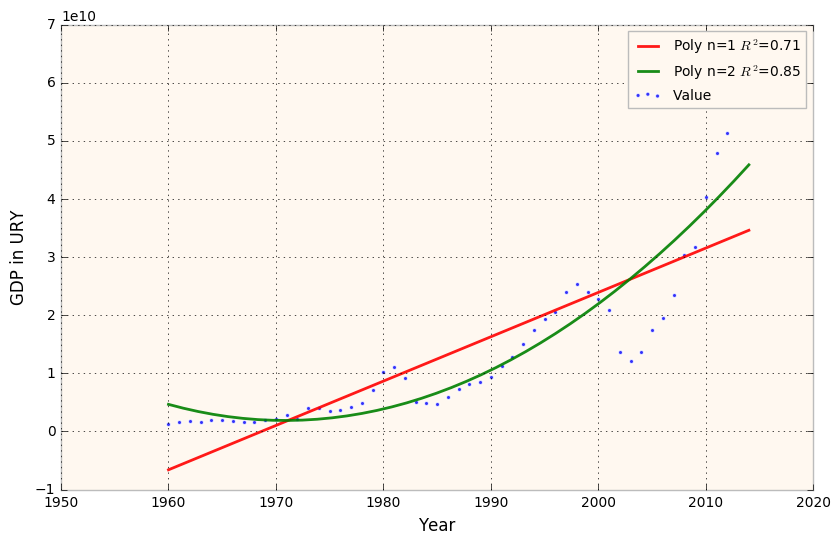

In [91]:
pl.figure(figsize=(6 * 1.618, 6))
pl.scatter(dfGdp.Year, dfGdp.Value,  s=10, alpha=0.8 )
pl.plot(X_prime[:, 1], y_hat, 'r', alpha=0.9, label='Poly n=1 $R^2$=%.2f' % est.rsquared)
pl.xlabel("Year")
pl.ylabel("GDP in URY")

# Fitting second degree polynomial
# points linearlyd space on lstats from minimum to maximom, 100 points
x = pd.DataFrame({'Year': np.linspace(dfGdp.Year.min(), dfGdp.Year.max(), 40)})
poly_2 = smf.ols(formula='Value ~ 1 + Year + I(Year ** 2.0)', data=dfGdp).fit()
pl.plot(x, poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % poly_2.rsquared, 
         alpha=0.9)
pl.legend()